In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import utils2p.synchronization
import yaml
from pathlib import Path
from scipy import signal
from rye2p import convert_raw_fn_thorimage, process_thorsync, datadirs, thormatch, olf_configs
import json

# set upstairs or downstairs microscope
microscope = 'downstairs-2p'

# set project directory paths
PRJ_DATA_DIR = Path("/local/tensor/Ruoyi/ruoyi_rotation_project")
RAW_DATA_DIR = Path("/local/tensor/Ruoyi/ruoyi_rotation_project/raw_data")
NAS_PROC_DIR = Path("/local/tensor/Ruoyi/ruoyi_rotation_project/processed_data")
OLF_CONFIG_DIR = PRJ_DATA_DIR / "olfactometer_configs"


setting project paths for None


In [2]:
print(matplotlib.get_configdir())
matplotlib.style.reload_library()
matplotlib.style.use('remy-default')


/home/remy/.config/matplotlib


In [3]:
def load_thorsync_line_mapping(microscope_name):
    """Load ThorSync line name mapping config"""
    line_config_folder = Path("/home/remy/PycharmProjects/rye2p/data/microscopes")

    thorsync_line_file = line_config_folder.joinpath(
            f"{microscope_name}/thorsync_lines.yaml"
            )

    with open(thorsync_line_file, 'r') as f:
        matched_lines = yaml.safe_load(f)

    return matched_lines

# ThorSync pre-processing demo

We convert .raw ThorImage movies into more easily readable .tif stacks, and save them to a processed data folder.

The Experiment.xml file is also copied to the processed data folder, and important information about the ThorImage
recording is saved to `thorimage_settings.yaml`.

# Set dataset info

ThorImage and ThorSync files are assumed to be stored in `RAW_DATA_DIR` in directories with the following structure:
```
raw_data/
+-- {{date_imaged}}
    +-- {{fly_num}}
        +-- {{thorimage_name}}
        +-- {{thorsync_name}}
```

We save the preprocessed outputs to:
```
processed_data/
+-- {{date_imaged}}
    +-- {{fly_num}}
        +-- {{thorimage_name}} # proc_mov_dir
            +-- timestamps.npy
```

In [4]:
date_imaged = '2025-05-25'
thorsync_name = 'SyncData001'
olf_config = '20250525_131507_stimuli.yaml'


# Set these manually if desired
thorsync_folder = RAW_DATA_DIR.joinpath(date_imaged,
                                        'PID',
                                        thorsync_name)

proc_mov_dir = NAS_PROC_DIR.joinpath(date_imaged, 'PID', thorsync_name)
proc_mov_dir.mkdir(parents=True, exist_ok=True)

# Convert olfactometer config

In [5]:
olf_config_file = OLF_CONFIG_DIR.joinpath(olf_config)

df_pins2odors, df_stim = olf_configs.parse_olf_config_file_downstairs(
        olf_config_file, is_two_component_ramp=False)

# save stim info
df_pins2odors.to_csv(proc_mov_dir.joinpath('df_pins2odors.csv'), sep="\t")
df_stim.to_csv(proc_mov_dir.joinpath('df_stim.csv'), sep="\t")

stim_list = dict(stim_list_flatstr=df_stim['stim'].to_list())
with open(proc_mov_dir.joinpath('stim_list.json'), "w") as f:
    json.dump(stim_list, f)

# Load ThorSync lines

## Get the line names

There are some ThorSync line that we usually want to load from the .h5 file. The line names are inconsistent across
microscopes due to varying lower/upper-case and spacing.

We use a dictionary of line name mappings so we can find and load them consistently.
```
rye2p/data/microscopes
--+ downstairs_2p
    --+ thorsync_lines.yaml
```

Alternatively, set the line name mappings yourself manually.

```python
line_mapping = load_thorsync_line_mapping(microscope_name)

line_mapping = {'piezo_monitor': 'Piezo Monitor',
                 'pockels_monitor': 'Pockels1 Monitor',
                 'olf_disp_pin': 'olfDispPin',
                 'pid': 'pid',
                 'frame_counter': 'Frame Counter',
                 'lightpath_shutter': 'flipperMirror',
                 'frame_in': 'Frame In',
                 'frame_out': 'Frame Out',
                 'scope_pin': 'scopePin'}
```

To look at the data inside the .h5 file (to check the actual line names), do the following:

```python
from rye2p.thorsync.utils import preview_hdf5

preview_hdf5.utils.preview_hdf5(thorsync_folder.joinpath('Episode001.h5'))
```
Output:
```
AI
	<HDF5 dataset "Piezo Monitor": shape (28331999, 1), type "<f8">
	<HDF5 dataset "Pockels1 Monitor": shape (28331999, 1), type "<f8">
	<HDF5 dataset "ai2": shape (28331999, 1), type "<f8">
	<HDF5 dataset "ai5": shape (28331999, 1), type "<f8">
	<HDF5 dataset "flipperMirror": shape (28331999, 1), type "<f8">
	<HDF5 dataset "olfDispPin": shape (28331999, 1), type "<f8">
	<HDF5 dataset "pid": shape (28331999, 1), type "<f8">
	<HDF5 dataset "scopePin_OLD": shape (28331999, 1), type "<f8">
CI
	<HDF5 dataset "Frame Counter": shape (28331999, 1), type "<u4">
DI
	<HDF5 dataset "Bleach Complete": shape (28331999, 1), type "<u4">
	<HDF5 dataset "Bleach Out": shape (28331999, 1), type "<u4">
	<HDF5 dataset "Digital 01": shape (28331999, 1), type "<u4">
	<HDF5 dataset "Frame In": shape (28331999, 1), type "<u4">
	<HDF5 dataset "Frame Out": shape (28331999, 1), type "<u4">
	<HDF5 dataset "Line 4": shape (28331999, 1), type "<u4">
	<HDF5 dataset "Line 7": shape (28331999, 1), type "<u4">
	<HDF5 dataset "scopePin": shape (28331999, 1), type "<u4">
Global
	<HDF5 dataset "GCtr": shape (28331999, 1), type "<u8">
```

In [6]:
# Load the ThorSync line mappings
line_mapping = load_thorsync_line_mapping('downstairs-2p')
line_mapping

{'piezo_monitor': 'Piezo Monitor',
 'pockels_monitor': 'Pockels1 Monitor',
 'olf_disp_pin': 'olfDispPin',
 'pid': 'pid',
 'frame_counter': 'Frame Counter',
 'lightpath_shutter': 'flipperMirror',
 'frame_in': 'Frame In',
 'frame_out': 'Frame Out',
 'scope_pin': 'scopePin'}

In [7]:
thorsync_folder

PosixPath('/local/tensor/Ruoyi/ruoyi_rotation_project/raw_data/2025-05-25/PID/SyncData001')

## Load the ThorSync lines from .h5 file

Read from `{{thorsync_folder}}/Episode001.h5`, and make the corresponding timestamps.

In [8]:
# Load lines from ThorSync .h5 file
# Load them from Episode001.h5 with values from `line_mapping`
# Save them as a dict with keys from `line_mapping`

sync_lines = utils2p.synchronization.get_lines_from_sync_file(
        thorsync_folder.joinpath('Episode001.h5'), line_mapping.values())

sync_lines = dict(zip(line_mapping.keys(), sync_lines))

### Make array of timestamps

In [9]:
# Load ThorSync metadata for frequency, and make timestamps using frequency
sync_meta = utils2p.synchronization.SyncMetadata(
        thorsync_folder.joinpath("ThorRealTimeDataSettings.xml")
        )

# %% Make timestamps for the entire ThorSync recording and add to `sync_lines`
sync_times = utils2p.synchronization.get_times(sync_lines['frame_counter'].size,
                                               sync_meta.get_freq()
                                               )

In [10]:
print(f"thorsync mlength (min): {sync_times.max() / 60.0}")

thorsync mlength (min): 24.15499888888889


## Downsample to a sampling rate of 1000 Hz

Decimate all lines, except `frame_counter`.

In [11]:
# Downsample to 1000 Hz signal
target_Fs = 1000
n_decimate = int(sync_meta.get_freq() / target_Fs)

sync_lines_ds = {k: signal.decimate(v, q=n_decimate) for k, v in sync_lines.items() if k != 'frame_counter'}
sync_lines_ds['frame_counter'] = sync_lines['frame_counter'][::n_decimate]
sync_lines_ds['time'] = sync_times[::n_decimate]

# save as compressed .npz file
np.savez_compressed(proc_mov_dir.joinpath('sync_lines.npz'), **sync_lines_ds)

## Reload decimated sync_lines

In [12]:
# Reload decimated sync lines
sync_lines = np.load(proc_mov_dir.joinpath('sync_lines.npz'))
sync_lines.files

['piezo_monitor',
 'pockels_monitor',
 'olf_disp_pin',
 'pid',
 'lightpath_shutter',
 'frame_in',
 'frame_out',
 'scope_pin',
 'frame_counter',
 'time']

In [13]:
# get sampling rate of timestamps
target_Fs = (1 / np.diff(sync_lines['time']).mean())
if target_Fs.is_integer():
    target_Fs = int(target_Fs)

# list line names
sync_lines.files

['piezo_monitor',
 'pockels_monitor',
 'olf_disp_pin',
 'pid',
 'lightpath_shutter',
 'frame_in',
 'frame_out',
 'scope_pin',
 'frame_counter',
 'time']

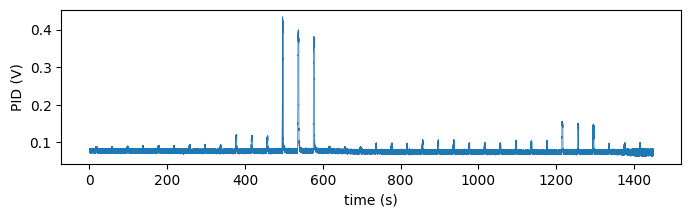

In [14]:
fig, ax = plt.subplots(figsize=(8, 2))
ax.plot(sync_lines['time'], sync_lines['pid'], lw=0.5)
ax.set(ylabel='PID (V)',
       xlabel='time (s)',
       # ylim=(0, 2)
       )
plt.show()

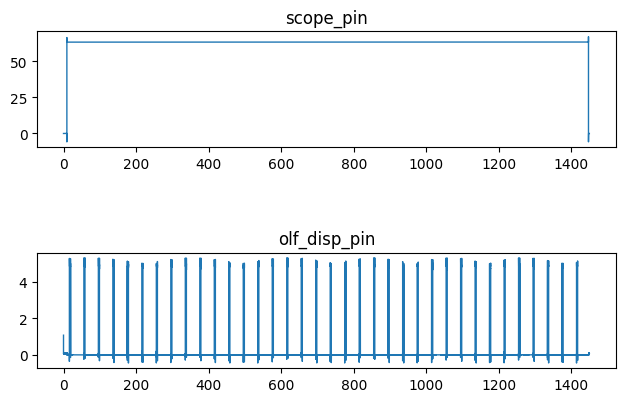

In [15]:
%matplotlib inline

# plot scope_pin and olf_disp_pin
with plt.ioff():
    fig, axarr = plt.subplots(2, 1)

for line, ax in zip(['scope_pin', 'olf_disp_pin'], axarr.flat):
    ax.plot(sync_lines['time'], sync_lines[line], lw=1)
    ax.set_box_aspect(0.2)
    ax.set_title(line)
plt.tight_layout()

plt.show()

 # Get raw frame timepoints

Next, for each frame, we extract the timestamps using `frame_counter`.

Note that this will probably not match the # of timepoints and frames in the ThorImage Experiment.xml file.


In [16]:
raw_frame_times = utils2p.synchronization.get_start_times(sync_lines['frame_counter'],
                                                          sync_lines['time'],
                                                          zero_based_counter=False)
sync_lines['frame_counter'].max()

print(f"frames in ThorSync recording: {raw_frame_times.size}")


frames in ThorSync recording: 0


# Process the lines that serve as TTL pulses

We want to scale these between 0 and 1, and then filter the signal based on an expected minimum pulse length.

We do this for the following lines:

- scope_pin
- olf_disp_pin
- frame_out
- lightpath_shutter

## Max scale TTL lines

In [17]:
# scale `scope_pin`
scope_pin = sync_lines['scope_pin'] / sync_lines['scope_pin'].max()
olf_disp_pin = sync_lines['olf_disp_pin'] / sync_lines['olf_disp_pin'].max()
# frame_out = sync_lines['frame_out'] / sync_lines['frame_out'].max()
lightpath_shutter = sync_lines['lightpath_shutter'] / sync_lines['lightpath_shutter'].max()

proc_sync_lines = dict(scope_pin=scope_pin,
                       olf_disp_pin=olf_disp_pin,
                       # frame_out=frame_out,
                       # lightpath_shutter=lightpath_shutter,
                       time=sync_lines['time']
                       )

## Find rising and falling edges

### Scope trigger
The microscope acquisition trigger onset/offset times are determined from `scope_pin`.

We compute `scope_ict`("initial cross time", i.e. the time when scope_pin goes high) and `scope_fct` ("final cross
time", i.e. the time when scope_pin goes low).

In [18]:
# With utils2p, Find rising and falling edges in olf_disp_pin

voltage_threshold = 0.8

scope_ici, = utils2p.synchronization.edges(scope_pin, size=voltage_threshold)
scope_fci, = utils2p.synchronization.edges(scope_pin, size=(-np.inf, -1 * voltage_threshold))

scope_ict = sync_lines['time'][scope_ici]
scope_fct = sync_lines['time'][scope_fci]

In [19]:

display('scope_ict')
display(scope_ict)

display('scope_fct')
display(scope_fct)

'scope_ict'

array([9.267])

'scope_fct'

array([1446.966])

### Olfactometer pin

In [20]:

### Find rising and falling edges in olf_disp_pin
voltage_threshold = 0.8

olf_ici = utils2p.synchronization.edges(olf_disp_pin, size=voltage_threshold)
olf_fci = utils2p.synchronization.edges(olf_disp_pin, size=(-np.inf, -1 * voltage_threshold))

olf_ict = sync_lines['time'][olf_ici]
olf_fct = sync_lines['time'][olf_fci]

In [21]:
olf_ict = olf_ict[(olf_ict > scope_ict[0]) & (olf_ict < scope_fct[0])]
olf_fct = olf_fct[(olf_fct > scope_ict[0]) & (olf_fct < scope_fct[0])]

In [22]:
# Alternatively, use scipy.signal.find_peaks
peaks, peak_props = signal.find_peaks(olf_disp_pin,
                                      height=0.5,
                                      width=2 * target_Fs)
peak_olf_ict = sync_lines['time'][peak_props['left_ips'].round().astype('int')]
peak_olf_fct = sync_lines['time'][peak_props['right_ips'].round().astype('int')]



## Plot the processed lines and extracted onset/offset times

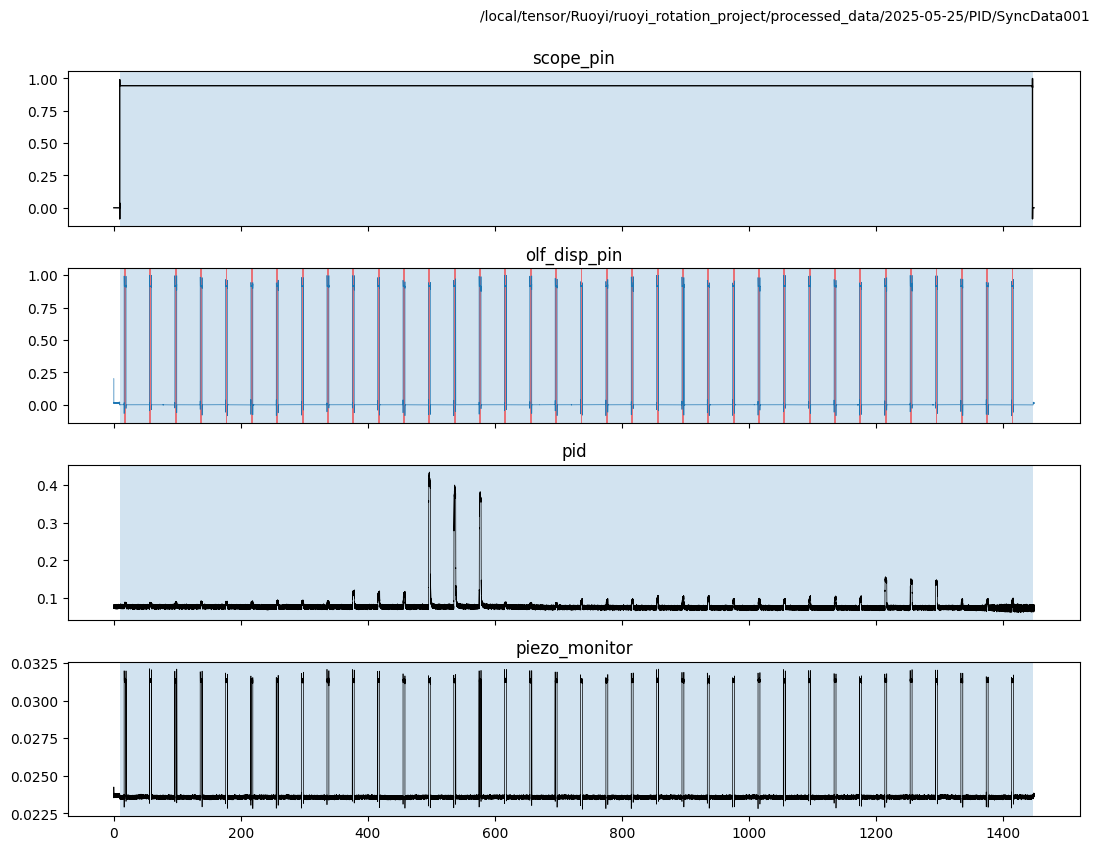

In [23]:
%matplotlib inline

fig, axarr = plt.subplots(4, 1, figsize=(11, 8.5),
                          sharex=True, sharey=False)

# scope pin
axarr[0].plot(proc_sync_lines['time'], proc_sync_lines['scope_pin'], lw=1, color='k')
axarr[0].set_title('scope_pin')
# for ict, fct in zip(scope_ict, scope_fct):
#     axarr[0].axvspan(ict, fct, alpha=0.5, zorder=0, )

axarr[1].plot(proc_sync_lines['time'], proc_sync_lines['olf_disp_pin'], lw=0.5)
axarr[1].set_title('olf_disp_pin')
for ict, fct in zip(olf_ict, olf_fct):
    axarr[1].axvspan(ict, fct, alpha=0.5, color='r', lw=0, zorder=0.5)

ax = axarr[2]
ax.plot(sync_lines['time'], sync_lines['pid'], lw=0.5, color='k')
ax.set_title('pid')

ax = axarr[3]
ax.plot(sync_lines['time'], sync_lines['piezo_monitor'], lw=0.5, color='k')
ax.set_title('piezo_monitor')
ax.figure.suptitle(str(proc_mov_dir),
                   fontsize=10, va='top', ha='right', y=0.995, x=0.995
                   )

for ax in axarr.flat:
    for ict, fct in zip(scope_ict, scope_fct):
        ax.axvspan(ict, fct, alpha=0.2, zorder=0, lw=0)

# axarr[3].set_ylim((-0.1, 3))
plt.tight_layout()
fig.canvas.draw()

In [24]:
ax.figure.savefig(proc_mov_dir / "sync_lines_processed.png", dpi=300)

# Scope trigger
The microscope acquisition trigger onset/offset times are determined from `scope_pin`.

We compute `scope_ict`("initial cross time", i.e. the time when scope_pin goes high) and `scope_fct` ("final cross
time", i.e. the time when scope_pin goes low).

Process ThorSync lines

We want to extract frame timestamps and olfactometer onset/offset times.

To extract frame timestamps, we need to use the following lines from ThorSync:
- `frame_counter`: We use `frame_counter` increments as the time when a frame was acquired.
- `scope_pin`: In stimulus-triggered mode, the microscope acquires images for as long as `scope_pin` is high. Once
`scope_pin` is low, it will stop acquiring, but it often collects images for a small time window after.

Note that the value of `frame_counter` usually doesn't match the frame number in the ThorImage `Experiment.xml` file.

This is because `frame_counter` increments whenever the microscope acquires a new frame. Not all of these frames are
saved to the .raw movie. We want to extract the timestamps of ONLY the frames that were saved to the .raw file.

Therefore, we must filter the raw frame times computed from `frame_counter` to match the number of frames and
timepoints
in the ThorImage metadata.


In [25]:
# # Load Thorimage settings
# with open(proc_mov_dir.joinpath('thorimage_settings.yaml'), 'r') as f:
#     thorimage_settings = yaml.safe_load(f)
#
# thorimage_settings['thorsync_name'] = thorsync_name
#
# thorimage_settings

# Save PID-related timestamps

In [26]:
# Save relevant ThorSync files

timestamps = dict(
        scope_ict=scope_ict,
        scope_fct=scope_fct,
        olf_ict=olf_ict,
        olf_fct=olf_fct,
        )
np.save(proc_mov_dir.joinpath('timestamps.npy'), timestamps)